# PairwiseExperiments
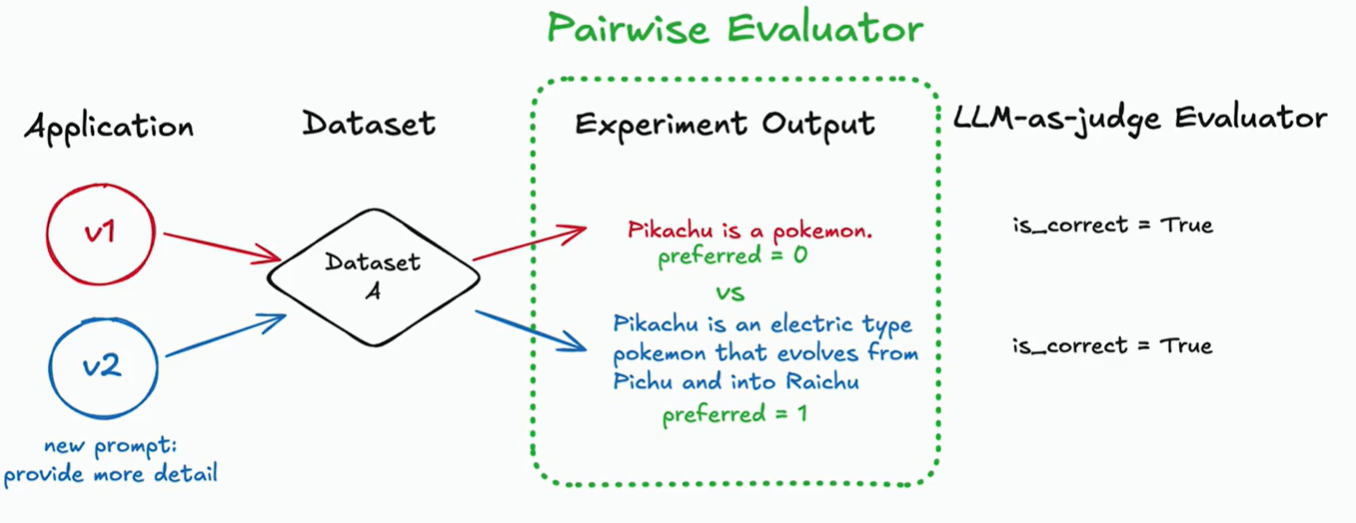

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Task
Let's set up a new task! Here, we have a salesperson named Bob
* Bob (salesperson) wants to summarize deal meeting transcripts. He's testing different prompts to generate concise summaries.
* Dataset: Bob's deal transcripts - no reference outputs (not a golden dataset), just input examples for prompt iteration.

In [2]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
  "https://smith.langchain.com/public/9078d2f1-7bef-4ba7-b795-210a17682ef9/d"
)

### Experiments
Now, let's run some experiments on this dataset using two different prompts. Let's add an evaluator that tries to score how good our summaries are!

In [3]:
from pydantic import BaseModel, Field
from openai import OpenAI

openai_client = OpenAI()

SUMMARIZATION_SYSTEM_PROMPT = """You are a judge, aiming to score how well a summary summarizes the content of a transcript"""

SUMMARIZATION_HUMAN_PROMPT = """
[The Meeting Transcript] {transcript}
[The Start of Summarization] {summary} [The End of Summarization]"""

class SummarizationScore(BaseModel):
    score: int = Field(description="""A score from 1-5 ranking how good the summarization is for the provided transcript, with 1 being a bad summary, and 5 being a great summary""")
    
def summary_score_evaluator(inputs: dict, outputs: dict) -> list:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": SUMMARIZATION_SYSTEM_PROMPT,
            },
            {
                "role": "user",
                "content": SUMMARIZATION_HUMAN_PROMPT.format(
                    transcript=inputs["transcript"],
                    summary=outputs.get("output", "N/A"),
                )}
        ],
        response_format=SummarizationScore,
    )

    summary_score = completion.choices[0].message.parsed.score
    return {"key": "summary_score", "score": summary_score}

First, we'll run our experiment with a good version of our prompt!

In [4]:
# Prompt One: Good Prompt!
def good_summarizer(inputs: dict):
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"Concisely summarize this meeting in 3 sentences. Make sure to include all of the important events. Meeting: {inputs['transcript']}"
            }
        ],
    )
    return response.choices[0].message.content

client.evaluate(
    good_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Good Summarizer"
)

c:\Users\palle\anaconda3\envs\MAT496\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Good Summarizer-b1960746' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/89baadeb-31fd-4907-b31a-ef68169f0cce/compare?selectedSessions=a2cc05b5-281e-461e-b501-d680de88ca35




5it [00:16,  3.22s/it]


,inputs.transcript,outputs.output,error,feedback.summary_score,execution_time,example_id,id
0,Bob and Ms. Nguyen (NO DEAL): Bob: Good aftern...,"In the meeting, Bob and Ms. Nguyen discussed h...",None,5,3.436166,04ea478c-9971-480f-8302-b2dee92abe43,eb676125-ce68-4269-a7b3-7e5f0d713ffb
1,Bob and Mr. Johnson (CLOSED DEAL): Bob: Good m...,Bob and Mr. Johnson discussed SUV options at F...,None,5,1.939325,173683de-f1fa-4f9d-b141-abd87dc7617a,d9e29e02-4f4d-4227-be92-0cb74cf1bf63
2,"Bob and Ms. Thompson (NO DEAL): Bob: Hi, Ms. T...","During the meeting, Ms. Thompson expressed int...",None,5,1.894231,4d24c132-b2bb-4ccb-814e-41f5bb065ada,92b2b690-72e5-43b2-abdd-df09fbaeedb7
3,Bob and Mr. Carter (CLOSED DEAL): Bob: Welcome...,"In the meeting, Bob welcomed Mr. Carter, who e...",None,5,1.537755,5d270a39-7b30-4c52-93e7-24d84b271867,db8d8682-fd76-4fbc-8f60-0da32d1fd865
4,"Bob and Mr. Patel (CLOSED DEAL): Bob: Hello, M...","In their meeting, Bob and Mr. Patel discussed ...",None,5,2.127339,b647c486-8e09-414a-9b49-16b66197a3b6,0e7dbac2-4e43-4737-96a1-65050710f07d


Now, we'll run an experiment with a worse version of our prompt, to highlight the difference.

In [5]:
# Prompt Two: Worse Prompt!
def bad_summarizer(inputs: dict):
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"Summarize this in one sentence. {inputs['transcript']}"
            }
        ],
    )
    return response.choices[0].message.content

client.evaluate(
    bad_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Bad Summarizer"
)

View the evaluation results for experiment: 'Bad Summarizer-fd6b2a00' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/89baadeb-31fd-4907-b31a-ef68169f0cce/compare?selectedSessions=cd1c2136-cbed-432d-8bc0-e45f4a9ffa58




5it [00:11,  2.36s/it]


,inputs.transcript,outputs.output,error,feedback.summary_score,execution_time,example_id,id
0,Bob and Ms. Nguyen (NO DEAL): Bob: Good aftern...,"Bob suggested the Ford Fiesta, Mustang Mach-E,...",None,4,1.173096,04ea478c-9971-480f-8302-b2dee92abe43,927b25af-418a-483f-a4e5-39612165f0b1
1,Bob and Mr. Johnson (CLOSED DEAL): Bob: Good m...,Bob successfully closed a deal with Mr. Johnso...,None,5,1.934363,173683de-f1fa-4f9d-b141-abd87dc7617a,a68967d8-1f60-4726-9468-07884d666718
2,"Bob and Ms. Thompson (NO DEAL): Bob: Hi, Ms. T...",Bob and Ms. Thompson discussed her interest in...,None,4,1.614073,4d24c132-b2bb-4ccb-814e-41f5bb065ada,64bc64ae-2bed-4bc6-956d-d44dcdcb623d
3,Bob and Mr. Carter (CLOSED DEAL): Bob: Welcome...,Bob successfully assisted Mr. Carter in tradin...,None,5,1.322238,5d270a39-7b30-4c52-93e7-24d84b271867,1acb9309-1d68-4bc0-b278-4a7dce6870bd
4,"Bob and Mr. Patel (CLOSED DEAL): Bob: Hello, M...",Bob successfully sold a Ford Fusion Hybrid to ...,None,5,1.146695,b647c486-8e09-414a-9b49-16b66197a3b6,31a9c6c7-da95-42f2-a3b0-56f7755f83fa


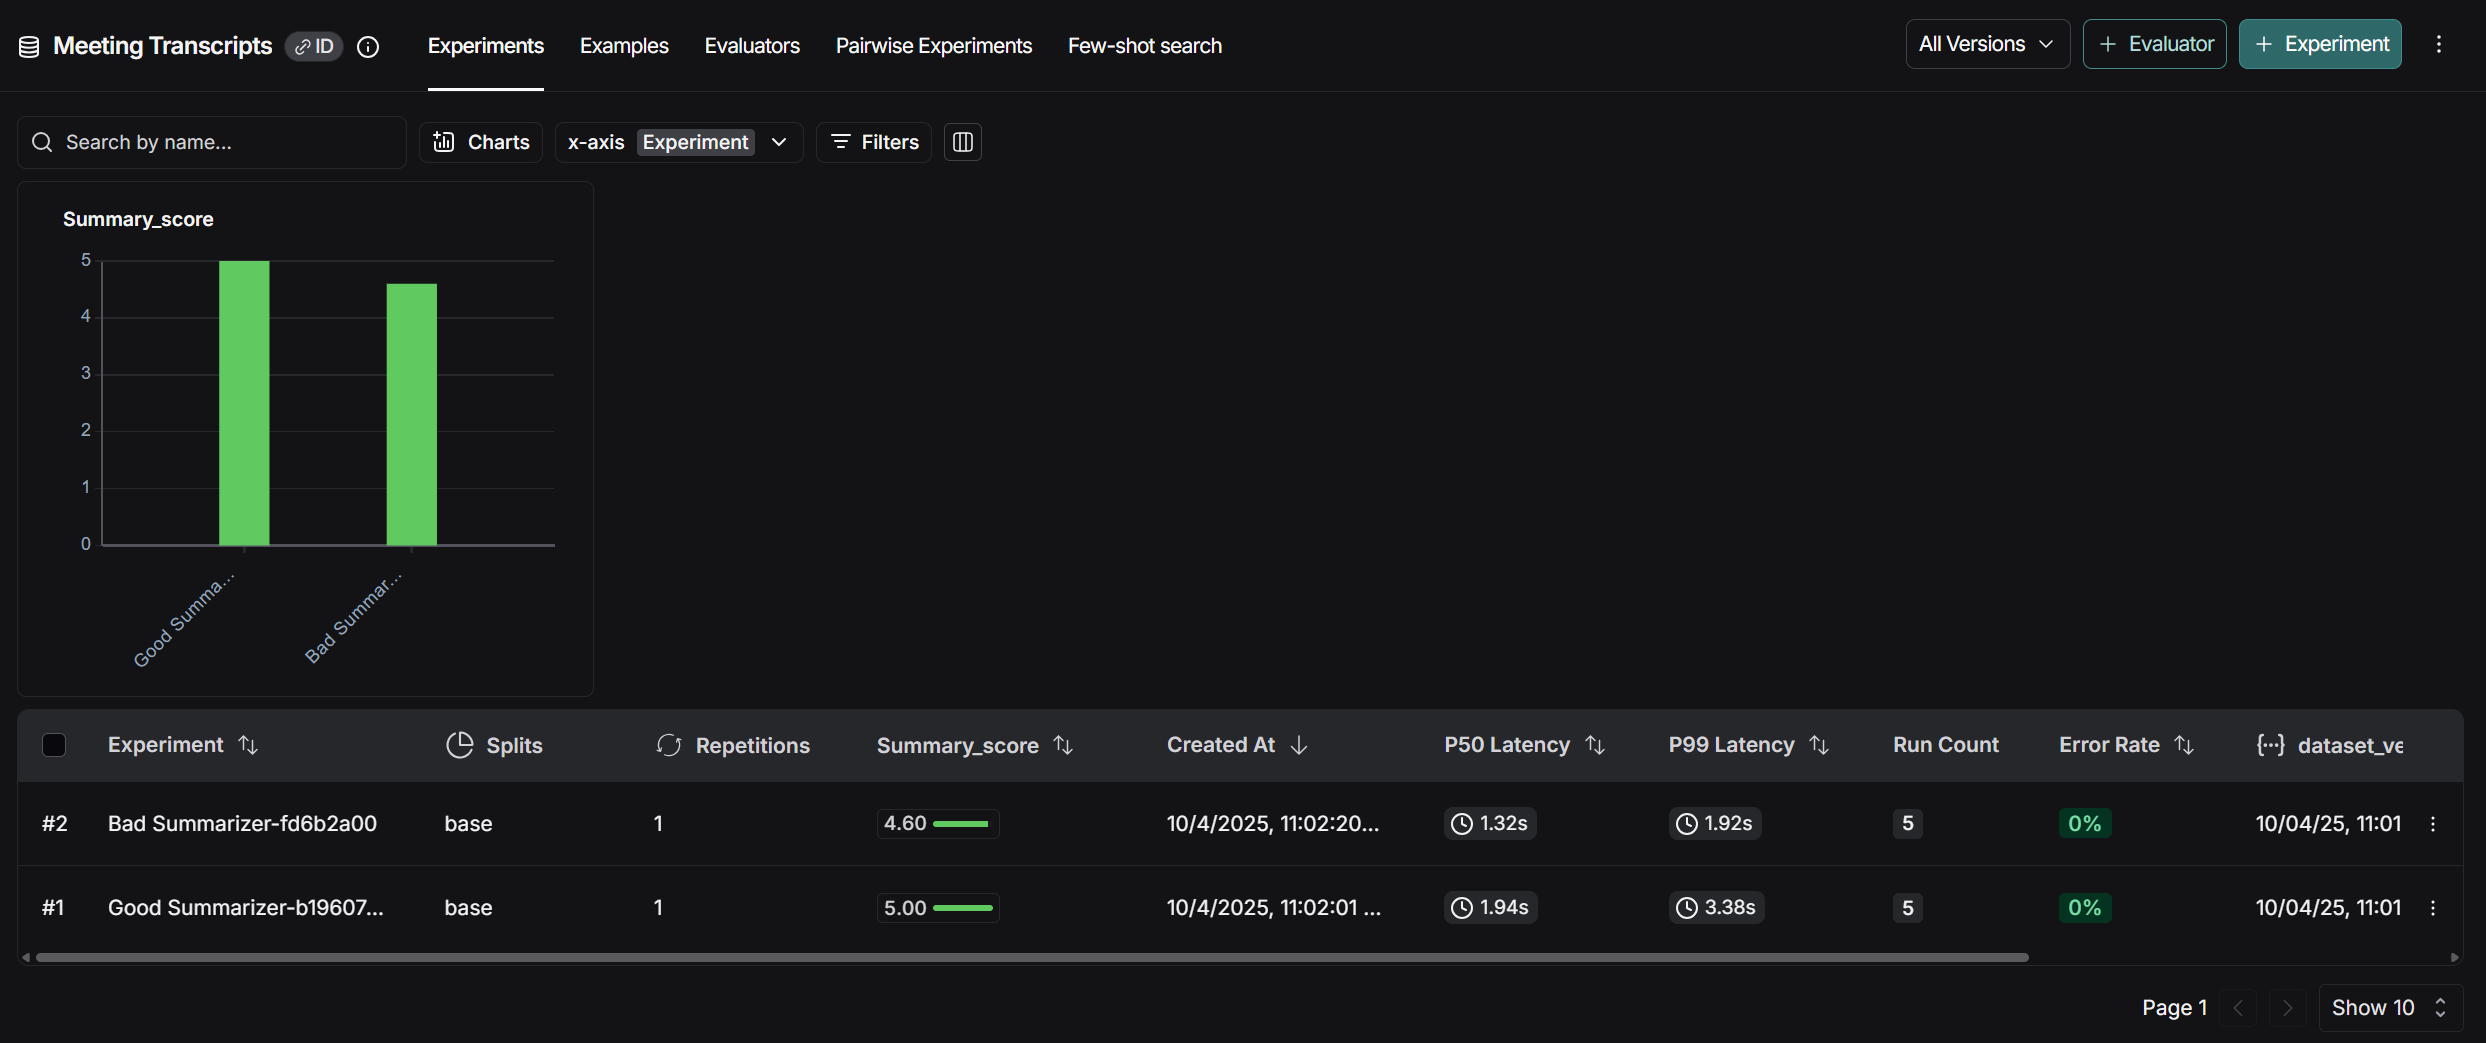

### Pairwise Experiment
* inputs: dict: A dictionary of the inputs corresponding to a single example in a dataset.
* outputs: list[dict]: A list of the dict outputs produced by each experiment on the given inputs.
* reference_outputs: dict: A dictionary of the reference outputs associated with the example, if available.
* runs: list[Run]: A list of the full Run objects generated by the experiments on the given example. Use this if you need access to intermediate steps or metadata about each run.
* example: Example: The full dataset Example, including the example inputs, outputs (if available), and metdata (if available).

Approach: LLM-as-Judge directly compares which summarizer is more helpful by evaluating them against each other, bypassing the need for reference outputs.


In [6]:
JUDGE_SYSTEM_PROMPT = """
Please act as an impartial judge and evaluate the quality of the summarizations provided by two AI summarizers to the meeting transcript below.
Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their summarizations. 
Begin your evaluation by comparing the two summarizations and provide a short explanation. 
Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. 
Do not favor certain names of the assistants. 
Be as objective as possible. """

JUDGE_HUMAN_PROMPT = """
[The Meeting Transcript] {transcript}

[The Start of Assistant A's Summarization] {answer_a} [The End of Assistant A's Summarization]

[The Start of Assistant B's Summarization] {answer_b} [The End of Assistant B's Summarization]"""

Our function will take in an inputs dictionary, and a list of outputs dictionaries for the different experiments that we want to compare.

In [7]:
from pydantic import BaseModel, Field

class Preference(BaseModel):
    preference: int = Field(description="""1 if Assistant A answer is better based upon the factors above.
2 if Assistant B answer is better based upon the factors above.
Output 0 if it is a tie.""")
    
def ranked_preference(inputs: dict, outputs: list[dict]) -> list:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": JUDGE_SYSTEM_PROMPT,
            },
            {
                "role": "user",
                "content": JUDGE_HUMAN_PROMPT.format(
                    transcript=inputs["transcript"],
                    answer_a=outputs[0].get("output", "N/A"),
                    answer_b=outputs[1].get("output", "N/A")
                )}
        ],
        response_format=Preference,
    )

    preference_score = completion.choices[0].message.parsed.preference

    if preference_score == 1:
        scores = [1, 0]
    elif preference_score == 2:
        scores = [0, 1]
    else:
        scores = [0, 0]
    return scores

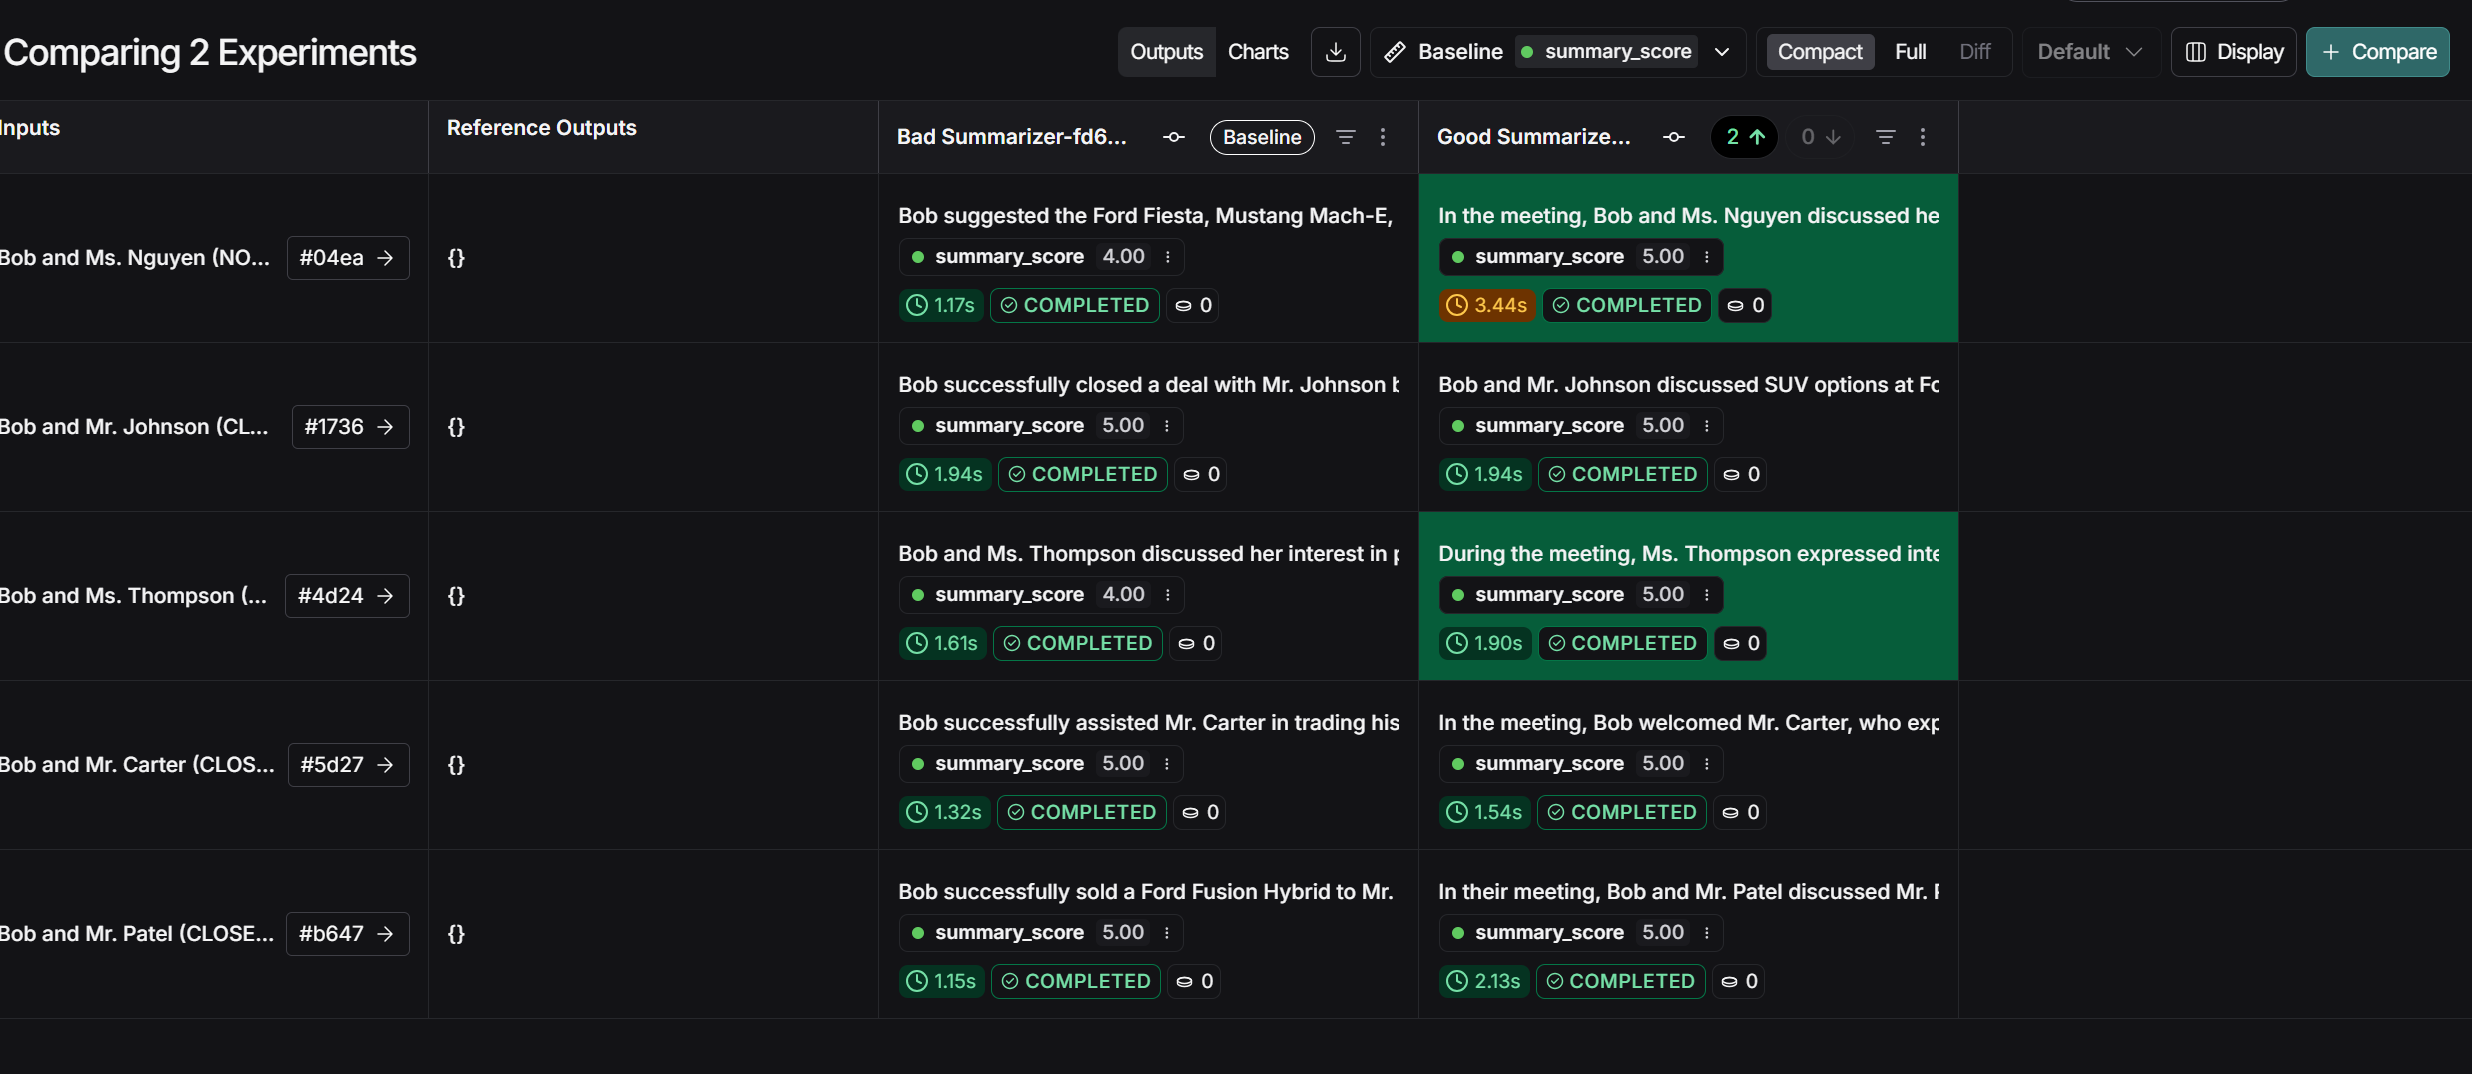

Now let's run our pairwise experiment with evaluate()

In [10]:
from langsmith import evaluate

evaluate(
    ("Good Summarizer-b1960746", "Bad Summarizer-fd6b2a00"),  # replaced ids
    evaluators=[ranked_preference]
)

View the pairwise evaluation results at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/89baadeb-31fd-4907-b31a-ef68169f0cce/compare?selectedSessions=a2cc05b5-281e-461e-b501-d680de88ca35%2Ccd1c2136-cbed-432d-8bc0-e45f4a9ffa58&comparativeExperiment=2f6953af-9feb-4f6c-ae1d-15a6fee7349d




100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
